# Chapter 04 - Training Models

## Linear Regression

### Generate data

In [1]:
# generate the data
import numpy as np

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

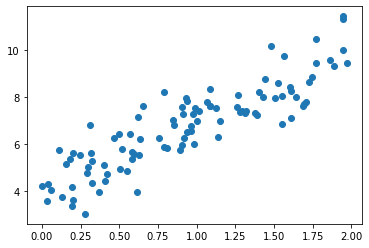

In [2]:
import matplotlib.pyplot as plt

plt.scatter(X, y)
plt.show()

### Performing linear regressing with the closed solution

In [3]:
X_b = np.c_[np.ones((100, 1)), X] # add X_0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [4]:
theta_best

array([[4.09477637],
       [2.85748763]])

This is our best parameters to fit the data. Let's make a prediction with them:

In [5]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.09477637],
       [9.80975164]])

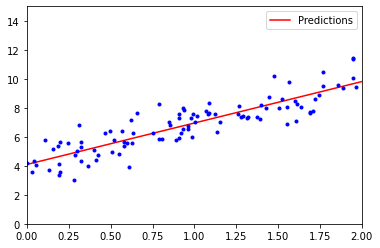

In [6]:
plt.plot(X_new, y_predict, "r-", label = "Predictions")
plt.legend()
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

### Performing linear regression using Scikit-Learn

In [7]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.09477637]), array([[2.85748763]]))

In [8]:
lin_reg.predict(X_new)

array([[4.09477637],
       [9.80975164]])

### Computational Complexity

Training a linear regression model using the normal equation can be hard for a machine depending on the approach you take. The computation complexity of inverting such a matrix is tipically about $O(n^{2.4})$ to $O(n^{3})$. 

The approach taken by Scikit-Learn, which consists in the Singular Value Decomposition (SVD) is much faster, about $O(n^2)$. However, both approaches get very slow when the number of features grow, even though, they scale nicely when it comes to the number of instances.

A better approach to the case when we have many features is shown next.

## Gradient Descent

### Gradient Descent

Gradient Descent is a generic optimization algorithm capable of finding optimal solutions to a wide range of problems. The general idea of Gradient Descent is to tweak parameters iteratively in order to minimize a cost function.

Since the purpose here is not to enter deeply into the mathematical aspects we won't dive into the partial derivates world.

Fortunately, the MSE cost function for a Linear Regression model happens to be a convex function, which means that if you pick any two points on the curve, the line segment joining them never crosses the curve. This implies that there are no local minima, just one global minimum. It is also a continuous function with a slope that never changes abruptly.

In fact, the cost function has the shape of a bowl, but it can be an elongated bowl if the features have very different scales. Next figure shows Gradient Descent on a training set where features 1 and 2 have the same scale (on the left), and on a training set where feature 1 has much smaller values than feature 2 (on the right).

![precision_recall_tradeoff](./images/ch04_linear_regression_cost_function.png)

As you can see, on the left the Gradient Descent algorithm goes straight toward the minimum, thereby reaching it quickly, whereas on the right it first goes in a direction almost orthogonal to the direction of the global minimum, and it ends with a long march down an almost flat valley. It will eventually reach the minimum, but it will take a long time.

That's why, when using the GD, you should ensure that all features have similar scale.

### Batch Gradient Descent

There are some strategies when implementing the GD. One of them is the batch gradient descent. Which consists of inputting the whole training  data into the model at once, such that we can calculate the partial derivatives all at one, meaning that to perform each update of the parameters we need to consume the whole dataset.

In [9]:
eta = 0.1 # learning rate
n_iterations = 1000
m = 100

theta = np.random.randn(2, 1) # random initialization

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients 

In [10]:
theta

array([[4.09477637],
       [2.85748763]])

Which is exactly what is found out from other solutions.

### Stochastic Gradient Descent

The main problem with Batch Gradient Descent is the fact that it uses the whole training set to compute the gradients at every step, which makes it very slow when the training set is large. At the opposite extreme, Stochastic Gradient Descent picks a random instance in the training set at every step and computes the gradients based only on that single instance. Obviously, working on a single instance at a time makes the algorithm much faster because it has very little data to manipulate at every iteration. It also makes it possible to train on huge training sets, since only one instance needs to be in memory at each iteration.

Besides, the stochasticity nature of SGD makes it possible to escape local minima points, helping the algorithm converging to the global minima. However, since it is stochastic, the algorithm will not settle down the global minima for too long. It will bounce around it. Nevertheless, we can implement a learning schedule to reduce the learning rate such that the algorithm will eventually stop bouncing around the global minima, if it reaches it. 

In [11]:
n_epochs = 50
t0, t1 = 5, 50 # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2, 1)

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
    

In [12]:
theta

array([[4.0723109 ],
       [2.87740079]])

Note that the GD descent iterated 1000 times over the whole training set, whereas SGD goes through it only 50 times and still reaches a good solution.

We can also use SGD with Scikit-Learn:

In [13]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None)

In [14]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.10749123]), array([2.87643662]))

### Mini-batch Gradient Descent

The last Gradient Descent algorithm we will look at is called Mini-batch Gradient Descent. It is simple to understand once you know Batch and Stochastic Gradient Descent: at each step, instead of computing the gradients based on the full training set (as in Batch GD) or based on just one instance (as in Stochastic GD), Mini-batch GD computes the gradients on small random sets of instances called mini-batches. The main advantage of Mini-batch GD over Stochastic GD is that you can get a performance boost from hardware optimization of matrix operations, especially when using GPUs.

![comparison_regression](./images/ch04_comparison_algo_regressions.png)

## Polynomial Regression

We can use a linear model to fit nonlinear data. A simple way to do this is to add powers of each feature as new features, then train a linear model on this extended set of
features. This technique is called Polynomial Regression.

In [15]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

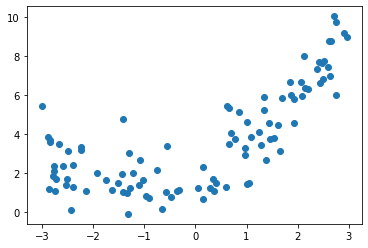

In [16]:
plt.scatter(X, y)

In [17]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-1.29654499])

In [18]:
X_poly[0]

array([-1.29654499,  1.68102892])

In [19]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.95198377]), array([[1.05020601, 0.48178761]]))

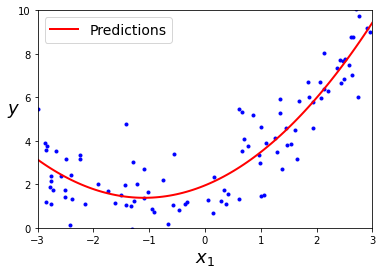

In [20]:
X_new = np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)

plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
plt.show()

## Learning Curves

We can detect that our model is underfitting or overfitting the training data by inspecting its performance on the training data against the test data. Another way to tell is to look at the learning curves: these are plots of the model’s performance on the training set and the validation set as a function of the training set size (or the training iteration). To generate the plots, train the model several times on different sized subsets of the training set. The following code defines a function that, given some training data, plots the learning curves of a model:

In [21]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
        
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend()
    plt.ylim(top=3, bottom=0)
    plt.xlabel('Training Set Size')
    plt.ylabel('RMSE')

### Underfitting with learning curves

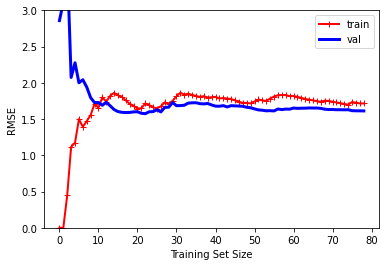

In [22]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

These learning curves are typical of a model that’s underfitting. Both curves
have reached a plateau; they are close and fairly high.

If your model is underfitting the training data, adding more training examples will not help. You need to use a more complex model or come up with better features.

### Overfitting with learning curves

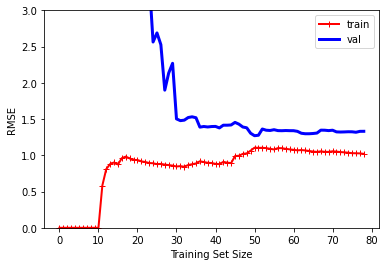

In [23]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
    ("lin_reg", LinearRegression())
])

plot_learning_curves(polynomial_regression, X, y)

The error on the training data is much lower than with the Linear Regression model.

There is a gap between the curves. This means that the model performs significantly better on the training data than on the validation data, which is the hallmark of an overfitting model. If you used a much larger training set, however, the two curves would continue to get closer.

## Regularized Linear Models


A good way to reduce overfitting is to regularize the model (constrain it). For a linear model, regularization is typically achieved by constraining the weights of the model. We will now look at **Ridge Regression**, **Lasso Regression**, and **Elastic Net**, which implement three different ways to constrain the weights.

### Ridge Regression

Ridge Regression (also called Tikhonov regularization) is a regularized version of Linear Regression: a regularization term equal to 

$$\alpha \Sigma_{i=1}^n \theta_i^2$$

is added to the cost function. This forces the learning algorithm to not only fit the data but also keep the model weights as small as possible.

_Note that the regularization term should only be added to the cost function during training. Once the model is trained, you want to use the unregularized performance measure to evaluate the model’s performance._

Ridge Regression Cost Function is given by

$$J(\theta) = MSE(\theta) + \frac{\alpha}{2} \Sigma_{i=1}^n \theta_i^2$$

Ridge Regression Closed-Form Solution

$$\hat{\theta} = (X^TX + \alpha A)^{-1} X^T y$$

Here is how to perform Ridge Regression with Scikit-Learn using a closed-form solution (a variant of the Equation above that uses a matrix factorization technique by André-Louis Cholesky):

In [24]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[5.10453037]])

In [25]:
# using SGD
sgd_reg = SGDRegressor(penalty="l2")
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([5.0850677])

### Lasso Regression

Least Absolute Shrinkage and Selection Operator Regression (usually simply called Lasso Regression) is another regularized version of Linear Regression: just like Ridge Regression, it adds a regularization term to the cost function, but it uses the ℓ1 norm of the weight vector instead of half the square of the ℓ2 norm.

Lasso Regression Cost Function

$$J(\theta) = MSE(\theta) + \alpha\Sigma_{i=1}^n |\theta|$$

An important characteristic of Lasso Regression is that it tends to eliminate the weights of the least important features (i.e., set them to zero). In other words, Lasso Regression automatically performs feature selection and outputs a sparse model (i.e., with few nonzero feature weights).

In [26]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([5.0672241])

In [27]:
# using SGD
sgd_reg = SGDRegressor(penalty="l1")
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([5.08098533])

### ElasticNet

Elastic Net is a middle ground between Ridge Regression and Lasso Regression.
The regularization term is a simple mix of both Ridge and Lasso’s regularization
terms, and you can control the mix ratio _r_. When _r_ = 0, Elastic Net is equivalent to Ridge Regression, and when _r_ = 1, it is equivalent to Lasso Regression (see Equation 4-12).

Elastic Net Cost Function 

$$J(\theta) = MSE(\theta) + r\alpha\Sigma_{i=1}^n|\theta_i| + \frac{1-r}{2}\alpha\Sigma_{i=1}^n \theta_i^2$$



In [28]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([5.0683215])

### Choosing regularization

So when should you use plain Linear Regression (i.e., without any regularization), Ridge, Lasso, or Elastic Net? It is almost always preferable to have at least a little bit of regularization, so generally you should avoid plain Linear Regression. **Ridge is a good default, but if you suspect that only a few features are useful, you should prefer Lasso or Elastic Net because they tend to reduce the useless features’ weights down to zero, as we have discussed**. In general, Elastic Net is preferred over Lasso because Lasso may behave erratically when the number of features is greater than the number of training instances or when several features are strongly correlated.

## Early Stopping

A very different way to regularize iterative learning algorithms such as Gradient
Descent is to stop training as soon as the validation error reaches a minimum.
This is called _early stopping_.

In [29]:
# from sklearn.base import clone
# from sklearn.preprocessing import StandardScaler

# # prepare the data
# poly_scaler = Pipeline([
#     ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
#     ("std_scaler", StandardScaler())
# ])

# X_train_poly_scaled = poly_scaler.fit_transform(X_train)
# X_val_poly_scaled = poly_scaler.transform(X_val)

# # Note that with warm_start=True, when the fit() method is called it continues
# # training where it left off, instead of restarting from scratch.

# sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
#                        penalty=None, learning_rate="constant", eta0=0.0005)

# minimum_val_error = float("inf")
# best_epoch = None
# best_model = None
# for epoch in range(1000):
#     sgd_reg.fit(X_train_poly_scaled, y_train) # continues where it left off
#     y_val_predict = sgd_reg.predict(X_val_poly_scaled)
#     val_error = mean_squared_error(y_val, y_val_predict)
#     if val_error < minimum_val_error:
#         best_epoch = epoch
#         best_model = clone(sgd_reg)

## Logistic Regression

### Definition

Logistic Regression (also called Logit Regression) is commonly used to estimate the probability that an instance belongs to a particular class (e.g., what is the probability that this email is spam?). If the estimated probability is greater than 50%, then the model predicts that the instance belongs to that class (called the positive class, labeled “1”), and otherwise it predicts that it does not (i.e., it belongs to the negative class, labeled “0”). This makes it a binary classifier.

The logistic regression output the logistic of the result of the regression

$$\hat{p} = h_{\theta}(x) = \sigma(x^T\theta)$$

where $\sigma$ is the sigmoid function.

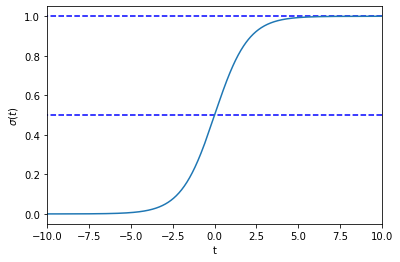

In [30]:
space = np.linspace(10, -10, 1000)
sigmoid = 1 / (1 + np.exp(-space))

plt.plot(space, 0.5*np.ones((1000, 1)), "--", c="b")
plt.plot(space, np.ones((1000, 1)), "--", c="b")
plt.plot(space, sigmoid)
plt.ylim(top=1.05, bottom=-0.05)
plt.xlim(left=-10, right=10)
plt.xlabel("t")
plt.ylabel("$\sigma(t)$")
plt.show()

Then, after estimating the probability $\hat{p}$, it can make its prediction $\hat{y}$.

The score _t_ is often called the logit because the logit function 

$$logit(p) = \log(\dfrac{p}{1 - p})$$

is the inverse of the logistic (sigmoid) function.

### Training and Cost Function

Now you know how a Logistic Regression model estimates probabilities and makes predictions. But how is it trained? The objective of training is to set the parameter vector θ so that the model estimates high probabilities for positive instances (y = 1) and low probabilities for negative instances (y = 0). This idea is captured by the cost function shown in Equation 4-16 for a single training instance x.

Cost Function for a single training instance:

$$c(\theta)= 
\begin{cases}
    -log(\hat{p}),  & \text{if } y = 1\\
    -log(1 - \hat{p}),  & \text{if } y = 0
\end{cases}
$$

This cost function makes sense because –log(t) grows very large when t approaches 0, so the cost will be large if the model estimates a probability close to 0 for a positive instance, and it will also be very large if the model estimates a probability close to 1 for a negative instance. On the other hand, –log(t) is close to 0 when t is close to 1, so the cost will be close to 0 if the estimated probability is close to 0 for a negative instance or close to 1 for a positive instance, which is precisely what we want.

The cost function over the whole training set is the average cost over all training
instances. It can be written in a single expression called the log loss:

$$J(\theta) = -\frac{1}{m}\Sigma_{i=1}^m [y^{(i)} \log({\hat{p}}^{(i)}) + (1 - y^{(i)}) \log({1 - \hat{p}}^{(i)})]$$

This cost function is convex and optization algorithms such as gradient descent can reach its global minima.

Logistic cost function partial derivatives:

$$\frac{\partial}{\partial \theta_j} J(\theta) = \frac{1}{m}\Sigma_{i=1}^m (\sigma(\theta^T x^{(i)}) - y^{(i)}) x_j^{(i)}$$

### Decision Boundaries

We are going to use the iris dataset to illustrate logistic regression. Let’s try to build a classifier to detect the Iris virginica type based only on the petal width feature.

In [31]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename']

In [32]:
iris["data"][0]

array([5.1, 3.5, 1.4, 0.2])

In [33]:
X = iris["data"][:, 3:] # petal width
y = (iris["target"] == 2).astype(int) # 1 if Iris virgina, else 0

In [34]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X, y)

LogisticRegression()

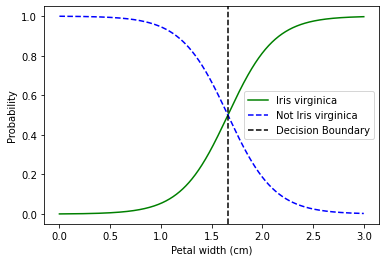

In [35]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
plt.plot(X_new, y_proba[:, 1], "g-", label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", label="Not Iris virginica")
plt.axvline(x=1.66, color='k', linestyle='--', label="Decision Boundary")
plt.xlabel("Petal width (cm)")
plt.ylabel("Probability")
plt.legend()
plt.show()

If the petal width is higher than 1.6 cm, the classifier will predict that the flower is an Iris virginica, and otherwise it will predict that it is not (even if it is not very confident):

In [36]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

Just like the other linear models, Logistic Regression models can be regularized using ℓ1 or ℓ2 penalties. Scikit-Learn actually adds an ℓ2 penalty by default.

### Softmax Regression (Multinomial Logistic Regression)

The Logistic Regression model can be generalized to support multiple classes directly, without having to train and combine multiple binary classifiers (as discussed in Chapter 3). This is called Softmax Regression, or Multinomial Logistic Regression.

The idea is that given an instance, the model will compute a score for each class K, then estimate the probability of each class by applying the softmax function.

Score computation:

$$s_k(\theta) = x^T \theta^{(k)}$$

Softmax function:

$$\hat{p}_k = \sigma(s(x))_k =\frac{\exp(s_k(x))}{\Sigma_{j=1}^K \exp(s_j(x))}$$

The softmax classifier predicts the class with the highest estimated probability:

$$\hat{y} = argmax_k \sigma(s(x))_k = argmax_k s_k(x) = argmax_k((\theta^{(k)})^T x)$$

The objective of the model if to estimate a high probability for the target class. For that purpose, we adopt the cross entropy cost function. Cross entropy is frequently used to measure how well a set of estimated class probabilities matches the target classes.

$$J(\Theta) = -\frac{1}{m}\Sigma_{i=1}^m \Sigma_{k=1}^K y_k^{(i)} \log(\hat{p}_k^{(i)})$$

*Notice that when there are just two classes (K = 2), this cost function is
equivalent to the Logistic Regression’s cost function (log loss).*

Cross entropy gradient vector for class k

$$\nabla_{\theta^{(k)}} J(\Theta) = \frac{1}{m}\Sigma_{i=1}^m (\hat{p}_k^{(i)} - y_k^{(i)}) x^{(i)}$$

In [37]:
X = iris["data"][:, (2, 3)] # petal length, petal width
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=10)
softmax_reg.fit(X, y)

LogisticRegression(C=10, multi_class='multinomial')

In [38]:
softmax_reg.predict([[5, 2]])

array([2])

In [39]:
softmax_reg.predict_proba([[5, 2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])